In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp

tickers = [
    "AAPL", "NVDA", "MSFT", "AMZN", "GOOGL", "GOOG", "META", "^SPX", "AVGO", "TSLA",
    "LLY", "WMT", "JPM", "V", "XOM", "MA", "UNH", "ORCL", "COST", "PG",
    "NFLX", "JNJ", "ABBV", "HD", "BAC", "KO", "TMUS", "CVX", "CRM", "CSCO",
    "MRK", "PM", "WFC", "IBM", "ABT", "LIN", "MCD", "GE", "PEP", "PLTR",
    "ACN", "TMO", "T", "AXP", "MS", "VZ", "DIS", "GS", "RTX", "NOW",
    "QCOM", "ISRG", "ADBE", "BX", "AMGN", "INTU", "PGR", "AMD", "CAT", "TXN",
    "DHR", "NEE", "UBER", "SPGI", "BKNG", "PFE", "BLK", "BSX", "UNP", "SYK",
    "SCHW", "GILD", "HON", "CMCSA", "VRTX", "C", "DE", "TJX", "AMAT", "COP",
    "LOW", "BA", "PANW", "FI", "MDT", "BMY", "ADP", "CB", "ETN", "MMC",
    "MU", "SBUX", "LMT", "NKE", "PLD", "ANET", "INTC", "ADI", "LRCX", "KKR"
]


In [2]:
inc = yf.download(tickers, period='3y')
t = yf.download(tickers= '^TYX', period='3y')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
inc = inc['Close']
t = t['Close']


In [4]:
rets = np.log(inc / inc.shift(1))
t = t/365
rets.drop(rets.index[0], inplace=True)
t.drop(t.index[0], inplace=True)  # Drops first row
t.drop(t.index[0], inplace=True)
t = t.reset_index()
rets = rets.reset_index()
rets = rets[rets.index < 252]
rf_rate =t[t.index < 252]['^TYX'].values

In [5]:
excess_returns = rets.merge(t, on = 'Date')
rets.drop(['Date'], axis = 1, inplace = True)
# didnt need excess returns as they are alread accounted for in the aclculation of sharpe, as we take into account the market premium
rf_rate =np.log(rf_rate +1)
# excess_returns.iloc[:, 1:-1] = excess_returns.iloc[:, 1:-1].sub(excess_returns["^TYX"], axis=0)

In [6]:
excess_returns.drop(['^TYX', 'Date'], axis = 1, inplace= True)

In [7]:
cov_matrix = rets.cov().values

In [10]:
mu = rets.mean(axis=0).values.reshape(-1, 1)
weights = cp.Variable( rets.shape[1])

In [11]:
target_return = cp.Parameter()

portfolio_return = mu.T @ weights
portfolio_variance = cp.quad_form(weights, cov_matrix)

problem = cp.Problem(
    cp.Minimize(portfolio_variance),
    [portfolio_return >= target_return, cp.sum(weights) == 1, weights >= 0, weights <= 0.3]
)

the constraint on the individual weights was eyeballed

In [12]:
import numpy as np

target_returns = np.linspace(np.percentile(mu, 10), np.percentile(mu,90), 200)
efficient_portfolios = []

for ret in target_returns:
    target_return.value = ret
    problem.solve()
    
    status = problem.status
    if status in ["optimal", "optimal_inaccurate"]:
        efficient_portfolios.append({
            'return': ret,
            'volatility': np.sqrt(portfolio_variance.value),
            'weights': weights.value
        })
    else:
        print(f"Problem could not be solved for return {ret}. Status: {status}")

In [13]:
np.percentile(mu,90)
np.percentile(mu,10)


np.float64(-0.001200804355547435)

In [14]:
weights_market = np.full(100, 0.01)
market_variance = np.dot(weights_market.T, np.dot(cov_matrix, weights_market))

sharpe_ratios = [(p['return'] - rf_rate.mean()) / p['volatility'] for p in efficient_portfolios]
tangency_portfolio = efficient_portfolios[np.argmax(sharpe_ratios)]

return_port = [rf_rate.mean() + (p['return'] - rf_rate.mean()) * market_variance / p['volatility'] for p in efficient_portfolios]

max_index = np.argmax(return_port)

if max_index < len(efficient_portfolios):
    tangency_portfolio_ = efficient_portfolios[max_index]
else:
    print(f"Error: Index {max_index} is out of range for list with length {len(efficient_portfolios)}")
    
    

In [15]:
np.dot(rets, weights_market).sum() -np.log(rf_rate+1).mean()

# out market return
market_variance
len(rets)
np.argmax(return_port)

np.int64(199)

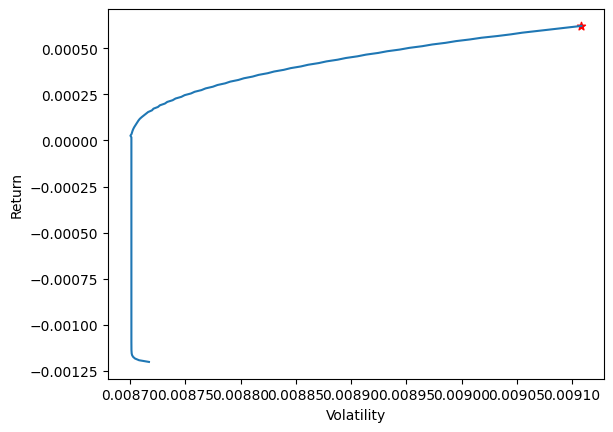

In [16]:
import matplotlib.pyplot as plt

plt.plot([p['volatility'] for p in efficient_portfolios], [p['return'] for p in efficient_portfolios])
plt.scatter(tangency_portfolio_['volatility'], tangency_portfolio_['return'], color='red', marker='*')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [17]:
weights_port = tangency_portfolio_['weights']
weights_port.max()

np.float64(0.1871000574675373)

In [37]:
rets_test = np.log(inc / inc.shift(1))
rets_test.drop(rets_test.index[0], inplace=True)
rets_test = rets_test.reset_index()
rets_test = rets_test[rets_test.index >= 252]
rets_test.drop(['Date'], axis = 1, inplace = True)


In [38]:
np.exp(np.dot(weights_port, rets_test.sum()/4))
# 5 years gives 14% annual return with no fees

np.float64(1.0284211620521608)

In [39]:
weights_market = np.full(100, 0.01)
current_rets = rets
weights_series = tangency_portfolio_['weights']

for ret in rets_test.values:
    
    current_rets = np.vstack([current_rets, ret.reshape(1, -1)])
    cov_matrix_updated = np.cov(current_rets, rowvar=False)
    
    market_variance = np.dot(tangency_portfolio_['weights'].T, np.dot(cov_matrix, tangency_portfolio_['weights']))
    
    return_port = [np.log(rf_rate+1).mean() + (p['return'] - np.log(rf_rate+1).mean()) * market_variance / p['volatility'] for p in efficient_portfolios]
    max_index = np.argmax(return_port)
    
    if max_index < len(efficient_portfolios):
        tangency_portfolio_ = efficient_portfolios[max_index]

    weights_series = np.vstack((weights_series, (tangency_portfolio_['weights'])))

In [40]:
def recalculate_markowitz_weights(current_rets, rf_rate, weights_var):
    """
    Recalculate the Markowitz model and return the optimal weights.
    
    Parameters:
    -----------
    current_rets : numpy.ndarray
        Current returns data
    rf_rate : float or numpy.ndarray
        Risk-free rate
    weights_var : cvxpy.Variable
        CVXPY variable for weights

    Returns:
    --------
    numpy.ndarray
        Optimal portfolio weights
    """
    mu = current_rets.mean(axis=0).reshape(-1, 1)
    current_rets = pd.DataFrame(current_rets)
    cov_matrix = (current_rets).cov().values
    current_rets = current_rets.values
    
    portfolio_return = mu.T @ weights_var
    cov_matrix = (cov_matrix + cov_matrix.T) / 2

    portfolio_variance = cp.quad_form(weights_var, cov_matrix)
    target_return_param = cp.Parameter()
    
    problem = cp.Problem(
        cp.Minimize(portfolio_variance),
        [portfolio_return >= target_return_param, cp.sum(weights_var) == 1, weights_var >= 0, weights_var <= 0.3]
    )
    target_returns = np.linspace(np.percentile(mu, 10), np.percentile(mu, 90), 100)
    efficient_portfolios = []
    for ret in target_returns:
        target_return_param.value = ret
        problem.solve()
        
        status = problem.status
        if status in ["optimal", "optimal_inaccurate"]:
            efficient_portfolios.append({
                'return': ret,
                'volatility': np.sqrt(portfolio_variance.value),
                'weights': weights_var.value
            })
    
    if efficient_portfolios:
        rf_mean = np.mean(rf_rate)
        sharpe_ratios = [(p['return'] - rf_mean) / p['volatility'] for p in efficient_portfolios]
        max_index = np.argmax(sharpe_ratios)
        if max_index < len(efficient_portfolios):
            return efficient_portfolios[max_index]['weights']
    
    return np.full(current_rets.shape[1], 1/current_rets.shape[1])

In [66]:

weights_market = np.full(100, 0.01)
updated_weights = []
current_rets = rets.copy().values
current_rf_rate = rf_rate[-1]
rf_rate_test = np.log(t[t.index >= 252]['^TYX'].values + 1)
weights = cp.Variable(current_rets.shape[1])
target_return = cp.Parameter()
initial_weights = recalculate_markowitz_weights(
    current_rets, 
    current_rf_rate, 
    weights, 
)
updated_weights.append(initial_weights.copy())
for i, ret in enumerate(rets_test.values):
    current_rets = np.vstack([current_rets, ret.reshape(1, -1)])
 
    weights = cp.Variable(current_rets.shape[1])
    
    if i > 0 and i % 10 == 0:
        print(f"Markowitz model at step {i}")
        optimal_weights = recalculate_markowitz_weights(
            current_rets, 
            rf_rate_test[i], 
            # need to make sure that the data for the rate comes in at the same time
            weights, 
        )
        updated_weights.append(optimal_weights.copy())
    else:
        # Use the most recent weights
        updated_weights.append(updated_weights[-1].copy())


Markowitz model at step 10
Markowitz model at step 20
Markowitz model at step 30
Markowitz model at step 40
Markowitz model at step 50
Markowitz model at step 60
Markowitz model at step 70
Markowitz model at step 80
Markowitz model at step 90
Markowitz model at step 100
Markowitz model at step 110
Markowitz model at step 120
Markowitz model at step 130
Markowitz model at step 140
Markowitz model at step 150
Markowitz model at step 160
Markowitz model at step 170
Markowitz model at step 180
Markowitz model at step 190
Markowitz model at step 200
Markowitz model at step 210
Markowitz model at step 220
Markowitz model at step 230
Markowitz model at step 240
Markowitz model at step 250
Markowitz model at step 260
Markowitz model at step 270
Markowitz model at step 280
Markowitz model at step 290
Markowitz model at step 300
Markowitz model at step 310
Markowitz model at step 320
Markowitz model at step 330
Markowitz model at step 340
Markowitz model at step 350
Markowitz model at step 360
M

In [77]:
updated_weights = pd.DataFrame(updated_weights)
df = updated_weights.copy()

In [ ]:

df = df.drop(df.index[-1])

df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,-0.000009,-6.452946e-07,-0.000005,-0.000009,-0.000012,-0.000008,-0.000006,-0.000014,-0.000017,0.097156,...,0.001645,-0.000002,-0.000007,-0.000005,-9.805719e-07,-0.000003,-0.000007,0.040647,0.064248,-0.000007
2,-0.000009,-6.452946e-07,-0.000005,-0.000009,-0.000012,-0.000008,-0.000006,-0.000014,-0.000017,0.097156,...,0.001645,-0.000002,-0.000007,-0.000005,-9.805719e-07,-0.000003,-0.000007,0.040647,0.064248,-0.000007
3,-0.000009,-6.452946e-07,-0.000005,-0.000009,-0.000012,-0.000008,-0.000006,-0.000014,-0.000017,0.097156,...,0.001645,-0.000002,-0.000007,-0.000005,-9.805719e-07,-0.000003,-0.000007,0.040647,0.064248,-0.000007
4,-0.000009,-6.452946e-07,-0.000005,-0.000009,-0.000012,-0.000008,-0.000006,-0.000014,-0.000017,0.097156,...,0.001645,-0.000002,-0.000007,-0.000005,-9.805719e-07,-0.000003,-0.000007,0.040647,0.064248,-0.000007
5,-0.000009,-6.452946e-07,-0.000005,-0.000009,-0.000012,-0.000008,-0.000006,-0.000014,-0.000017,0.097156,...,0.001645,-0.000002,-0.000007,-0.000005,-9.805719e-07,-0.000003,-0.000007,0.040647,0.064248,-0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,-0.000008,3.040077e-02,-0.000005,-0.000010,-0.000013,-0.000008,-0.000005,-0.000010,-0.000015,0.001852,...,-0.000007,-0.000005,-0.000007,-0.000004,-9.437580e-07,-0.000004,-0.000006,0.114272,0.022364,-0.000007
491,-0.000004,2.693008e-02,-0.000002,-0.000005,-0.000007,-0.000004,-0.000003,-0.000006,-0.000008,0.003813,...,-0.000004,-0.000002,-0.000004,-0.000002,-6.029052e-07,-0.000002,-0.000004,0.107056,0.035263,-0.000004
492,-0.000004,2.693008e-02,-0.000002,-0.000005,-0.000007,-0.000004,-0.000003,-0.000006,-0.000008,0.003813,...,-0.000004,-0.000002,-0.000004,-0.000002,-6.029052e-07,-0.000002,-0.000004,0.107056,0.035263,-0.000004
493,-0.000004,2.693008e-02,-0.000002,-0.000005,-0.000007,-0.000004,-0.000003,-0.000006,-0.000008,0.003813,...,-0.000004,-0.000002,-0.000004,-0.000002,-6.029052e-07,-0.000002,-0.000004,0.107056,0.035263,-0.000004


In [87]:
np.dot(df.values.T , rets_test)
print(np.isnan(rets_test).any())


Ticker
AAPL    False
ABBV    False
ABT     False
ACN     False
ADBE    False
        ...  
VZ      False
WFC     False
WMT     False
XOM      True
^SPX    False
Length: 100, dtype: bool


In [24]:
current_rets = rets.copy().values
weights = cp.Variable(current_rets.shape[1])
target_return = cp.Parameter()

mu = current_rets.mean(axis=0).reshape(-1, 1)
current_rets = pd.DataFrame(current_rets)
cov_matrix = (current_rets).cov().values
current_rets = current_rets.values

portfolio_return = mu.T @ weights
cov_matrix = (cov_matrix + cov_matrix.T) / 2

portfolio_variance = cp.quad_form(weights, cov_matrix)

problem = cp.Problem(
    cp.Minimize(portfolio_variance),
    [portfolio_return >= target_return, cp.sum(weights) == 1, weights >= 0, weights <= 0.3]
)

target_returns = np.linspace(np.percentile(mu.flatten(), 10), np.percentile(mu.flatten(), 90), 100)
target_returns

print(np.isnan(mu).any())


False


In [ ]:
current_rets = pd.DataFrame(current_rets)


array([[-0.01912367,  0.00946761,  0.00503445, ...,  0.00284293,
        -0.00518416, -0.01263116],
       [-0.01862325,  0.03298115,  0.00384255, ...,  0.02297305,
         0.01105919, -0.00976443],
       [ 0.00180246,  0.02554302,  0.0281965 , ...,  0.00995088,
         0.01659795,  0.00424437],
       ...,
       [ 0.00767216,  0.00656682,  0.00325364, ...,  0.00837429,
         0.05732545,  0.00369202],
       [-0.00325478, -0.00399755,  0.01184031, ..., -0.00986736,
        -0.0096042 , -0.00581384],
       [-0.01135465,  0.0063636 ,  0.01362269, ...,  0.01643682,
         0.01698239, -0.00249548]])

In [26]:
for ret in rets_test.values:
    print(ret.reshape(1, -1))
    current_rets = np.vstack([current_rets, ret.reshape(1, -1)])

[[ 0.00548103  0.00465346  0.00688531  0.00131434 -0.00372396 -0.01695214
   0.01369771 -0.02476731 -0.00097278 -0.00019727  0.00945074 -0.01865503
  -0.01017866 -0.0140668   0.0065026   0.00721005 -0.01221303  0.00054877
   0.021288   -0.01309282  0.00953565  0.00196448 -0.02063013  0.00412428
  -0.00608395 -0.01392483 -0.02268417 -0.0142322  -0.01067045 -0.01321382
  -0.01121795 -0.00299197  0.00060033 -0.01410789  0.00594637 -0.00692048
  -0.00335295  0.03694607  0.03711263  0.00270206 -0.00020801  0.00542269
  -0.0124888  -0.00060936  0.01895832 -0.00423391 -0.00278148 -0.00109759
  -0.01008882  0.0006367   0.00272415  0.01656374  0.00036729 -0.00432149
   0.00062806 -0.00639779  0.00308043  0.00037373  0.0216109   0.0069911
   0.00374593  0.00440459  0.02521248  0.02866868  0.00813745 -0.00886058
  -0.00564053  0.01233458  0.00578659  0.01079614 -0.01165484  0.00391322
  -0.00120404  0.00632662  0.00585605  0.00391808  0.01369034  0.00293277
  -0.00032515 -0.00558486 -0.00209937  

In [27]:
weights

Variable((100,), var3259)